<a href="https://colab.research.google.com/github/ashtonjlee/AI-vs-Human-Generated-Image-Detection/blob/main/timm_baseline_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model (Transfer Learning with EfficientNetV2 Small Model)

Taken from this [link](https://www.kaggle.com/code/vyacheslavshen/99-97-lb-baseline-with-timm). Use as a baseline to compare with our model.

In [ ]:
!pip install timm albumentations

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timm
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score
from tqdm import tqdm
import copy

import matplotlib.pyplot as plt
import cv2

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file names and labels.
            data_dir (str): Directory where the image files are stored.
            transforms (albu.Compose, optional): Albumentations transforms to apply to the images.
            is_train (bool, optional): Flag to indicate if the dataset is for training.
        """
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the file name and label
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        # Load the image
        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = np.array(image)  # Convert to NumPy array (Albumentations requires this format)

        # Apply transforms if specified
        if self.transforms:
            image = self.transforms(image=image)['image']

        # For training, return the image and label
        if self.is_train:
            return image, label
        # For inference, return only the image
        else:
            return image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 16
SEED = 42
IMG_SIZE = 384

# --- CONFIGURATION ---
DRIVE_ZIP_PATH = "/content/drive/MyDrive/archive-2.zip"
LOCAL_EXTRACT_DIR = "/content/dataset"
# ---------------------

# Check if need to unzip
if not os.path.exists(LOCAL_EXTRACT_DIR):
    print("New Runtime Detected")

    print(f"1. Copying zip from Drive to local disk...")
    # Copy to a temporary zip file
    !cp "{DRIVE_ZIP_PATH}" "/content/temp_data.zip"

    print("2. Unzipping... (This takes a moment)")
    # Unzip into the dataset folder
    !unzip -q "/content/temp_data.zip" -d "{LOCAL_EXTRACT_DIR}"

    # Delete temp zip file
    print("3. Cleaning up zip file...")
    !rm "/content/temp_data.zip"

    print("Done! Data extracted.")
else:
    print("Data already exists locally. Skipping unzip.")

# Load the train CSV
train_csv_path = "/content/dataset/archive-2/train.csv"
train_df = pd.read_csv(train_csv_path)

# Define the base directory where images are stored
train_data_dir = "/content/dataset/archive-2/"

train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=SEED, stratify=train_df['label'])

# Dataset and DataLoader
train_dataset = CustomDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataset = CustomDataset(val_df, train_data_dir, transforms=train_transform, is_train=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Iterate through the DataLoader
for images, labels in train_dataloader:
    print(images.shape, labels)
    break

for images, labels in val_dataloader:
    print(images.shape, labels)
    break

Data already exists locally. Skipping unzip.
torch.Size([16, 3, 384, 384]) tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])
torch.Size([16, 3, 384, 384]) tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])


In [ ]:
LR = 1e-5
NUM_EPOCHS = 2

# model = timm.create_model('vit_small_patch14_dinov2.lvd142m',
#                           pretrained=True,
#                          num_classes=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k',
                          pretrained=True,
                         num_classes=2)

optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

In [ ]:
def train_model(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, num_epochs=10, save_path="best_model.pth"
):
    """
    Trains the model and evaluates it on the validation set. Saves the model with the best F1 score.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer, e.g., AdamW.
        scheduler: Learning rate scheduler, e.g., StepLR.
        loss_fn: Loss function, e.g., CrossEntropyLoss.
        device: Device to train on (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train.
        save_path: Path to save the model with the best F1 score.

    Returns:
        best_model_wts: The weights of the model with the highest F1 score.
        history: A dictionary containing training and validation metrics.
    """
    model.to(device)  # Move model to the specified device

    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # To store the best weights
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    curr_step = 0
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()

        for batch_idx, (images, labels) in tqdm(enumerate(train_loader), desc="Training", total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            curr_step += 1
            if curr_step % 1000 == 0:
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                all_labels = []
                all_preds = []

                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)

                        outputs = model(images)
                        loss = loss_fn(outputs, labels)

                        val_loss += loss.item()
                        _, preds = torch.max(outputs, 1)

                        val_correct += (preds == labels).sum().item()
                        val_total += labels.size(0)

                        # Store labels and predictions for F1 score calculation
                        all_labels.extend(labels.cpu().numpy())
                        all_preds.extend(preds.cpu().numpy())

                val_loss /= len(val_loader)
                val_f1 = f1_score(all_labels, all_preds, average="weighted")

                # Save the best model weights based on validation F1 score
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_path)
                    print(f"New best model saved with F1 score: {best_f1:.4f}")


                train_loss /= 1000

                # Log metrics
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["val_f1"].append(val_f1)

                # Print results after 1k steps
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                # reset
                train_loss = 0.0
                train_total = 0
                train_correct = 0

                # Step the learning rate scheduler
                scheduler.step()

    print("Training complete.")
    print(f"Best F1 Score: {best_f1:.4f}")
    return best_model_wts, history

In [ ]:
best_model_wts, history = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path="best_model.pth",
)

# Load the best model weights after training
model.load_state_dict(best_model_wts)

Epoch 1/2
--------------------------------------------------


Training:   3%|▎         | 101/3498 [00:48<26:23,  2.15it/s]

In [ ]:
def visualize_history(history):
    """
    Visualizes the training and validation history.

    Args:
        history (dict): Dictionary containing training and validation metrics with keys:
                        - "train_loss": List of training loss values.
                        - "val_loss": List of validation loss values.
                        - "val_f1": List of validation F1 scores.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_f1"], label="Val F1 Score", marker="o", color="green")
    plt.title("Validation F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

visualize_history(history)


# Grad-CAM

Visualize how the baseline model makes its predictions.

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=3d5440abcf10ee88223a33a40432dd6f81731a3d43cf78316404a764be194921
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Config
IMG_SIZE = 384
NUM_CLASSES = 2
CLASS_NAMES = {0: "Human", 1: "AI"}
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/content/drive/MyDrive/best_model.pth"
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
MAX_IMAGES = 10

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=False, num_classes=NUM_CLASSES)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
def visualize_gradcam(model, image_tensor, original_image, label, prediction, filename, class_names, save_dir="gradcam_results"):
    os.makedirs(save_dir, exist_ok=True)
    target_layers = [model.conv_head]

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=image_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True) # overlay heatmap
    label_str = class_names.get(label, str(label))
    pred_str = class_names.get(prediction, str(prediction))

    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Show original
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original")
    ax[0].axis('off')

    # Show Grad-CAM
    ax[1].imshow(visualization)
    ax[1].set_title(f"Grad-CAM Heatmap, True: {label_str}, Pred; {pred_str}")
    ax[1].axis('off')

    # Save to disk
    save_path = os.path.join(save_dir, f"cam_{filename}")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"Saved Grad-CAM to {save_path}")
    plt.show()
    plt.close()

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img0.jpg


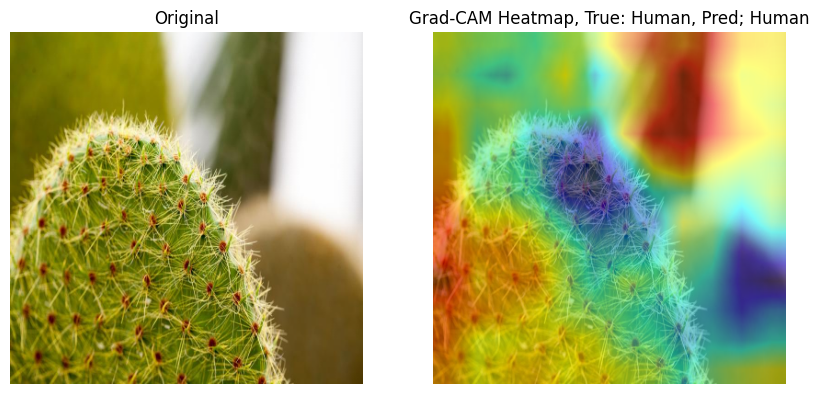

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img1.jpg


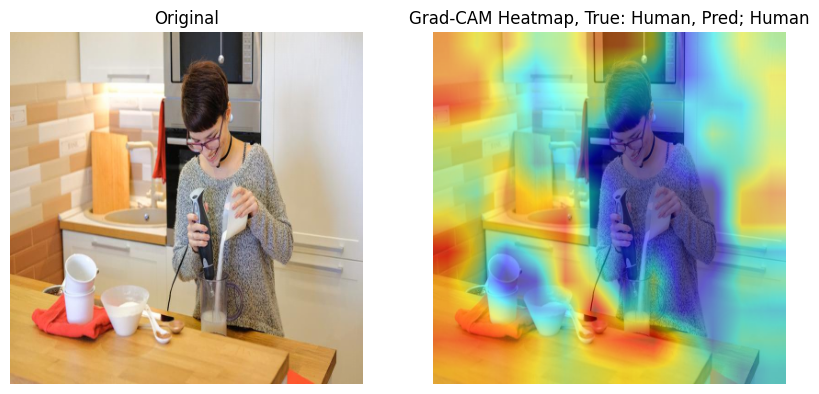

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img2.jpg


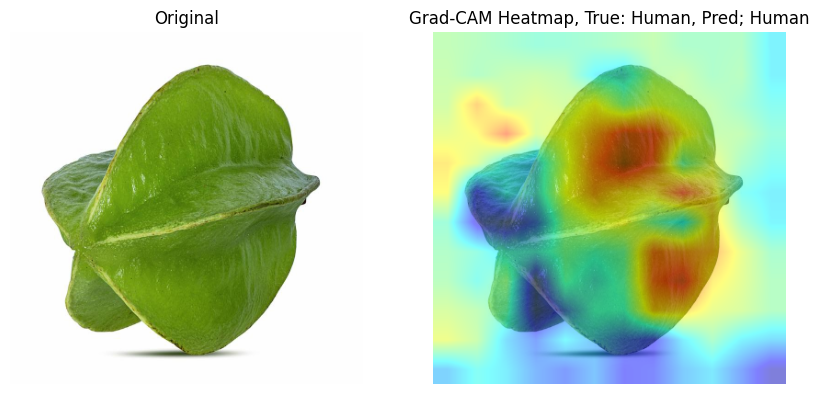

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img3.jpg


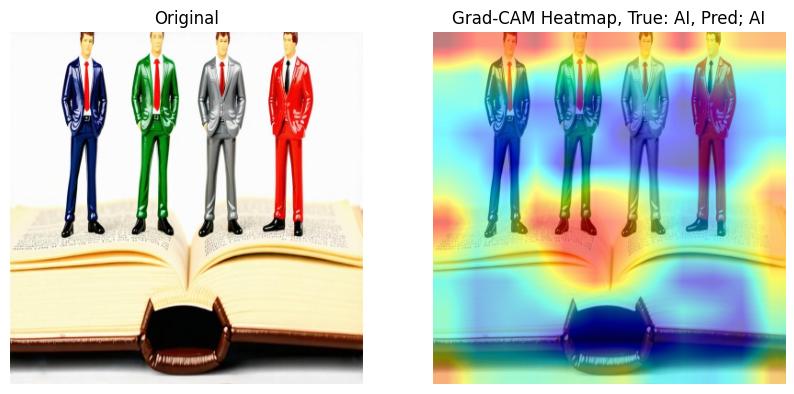

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img4.jpg


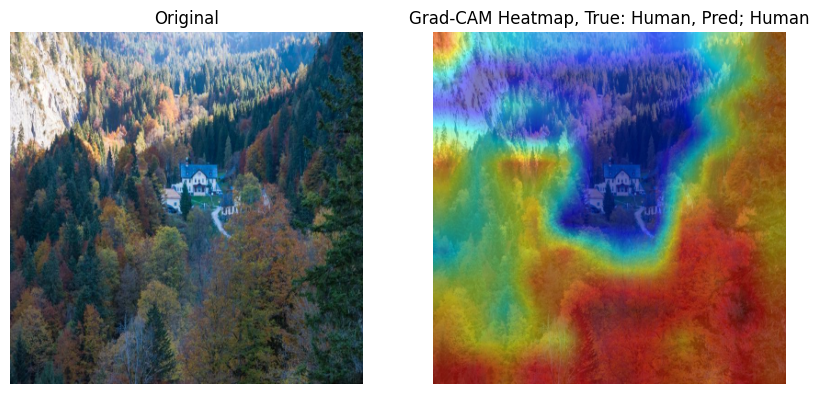

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img5.jpg


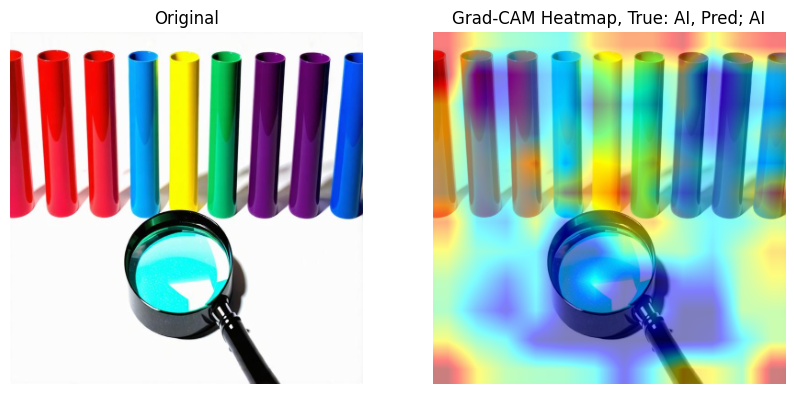

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img6.jpg


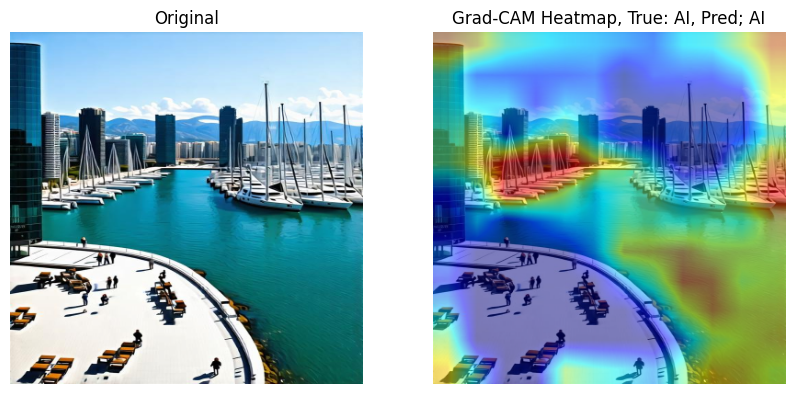

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img7.jpg


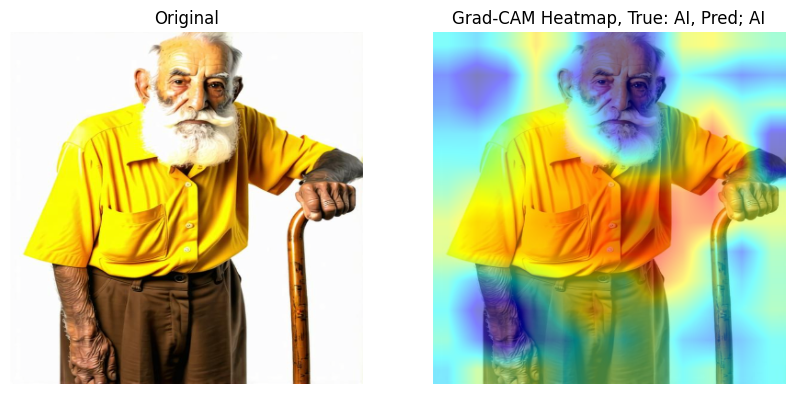

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img8.jpg


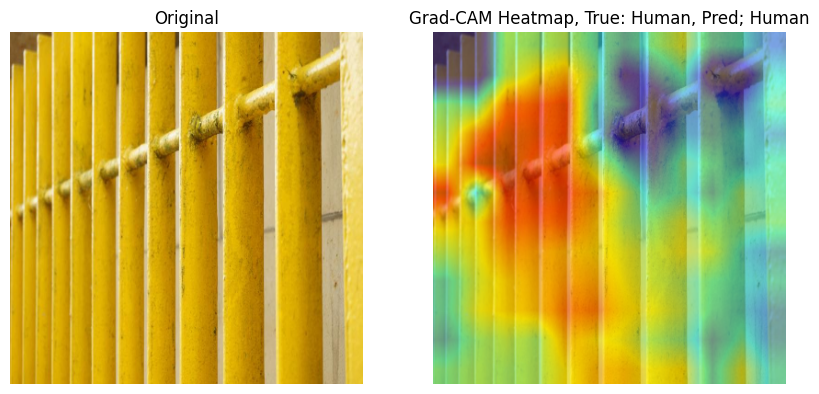

Saved Grad-CAM to gradcam_results/cam_Train_Batch0_Img9.jpg


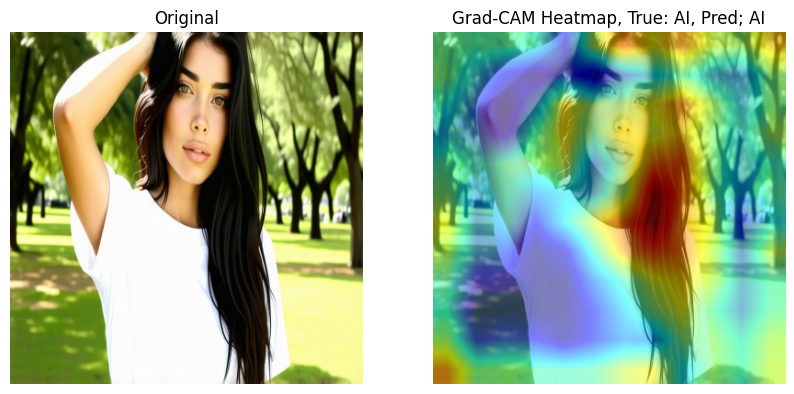

In [ ]:
count = 0

for batch_idx, (images, labels) in enumerate(train_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Get preds for whole batch
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(len(images)):
        if count >= MAX_IMAGES:
            break

        # Prepare inputs and denormalize
        input_tensor = images[i].unsqueeze(0)
        viz_img = images[i].cpu().permute(1, 2, 0).numpy()
        viz_img = viz_img * STD + MEAN
        viz_img = np.clip(viz_img, 0, 1)
        current_label = labels[i].item()
        current_pred = preds[i].item()

        dummy_filename = f"Train_Batch{batch_idx}_Img{i}.jpg"

        # Run gradCAM
        visualize_gradcam(
            model=model,
            image_tensor=input_tensor,
            original_image=viz_img,
            label=current_label,
            prediction=current_pred,
            filename=dummy_filename,
            class_names=CLASS_NAMES
        )

        count += 1

    if count >= MAX_IMAGES:
        break